In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# from model import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'model'

In [7]:
""" Full assembly of the parts to form the complete network """
import torch.nn.functional as F

""" Parts of the U-Net model """
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return logits

In [10]:
# load model and set to eval mode
model = UNet(n_channels=4, n_classes=1)
# model.load_state_dict(torch.load("../ckpt/0.8142160177230835_1729589887.964992.pth", weights_only=False))
# model.to(device=device, memory_format=torch.channels_last)
model.load_state_dict(torch.load("../ckpt/0.8142160177230835_1729589887.964992.pth", weights_only=False, map_location=torch.device('cpu')))
model.eval()
"ok"

'ok'

Path: datasets/datasets/BraTS2021_00621, frame: 60


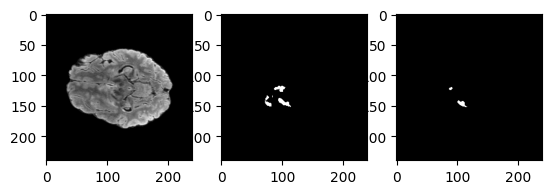

In [14]:
from data import get_data_path, load_data
THRESHOLD = 0.7
IMG_TYPE = ("flair", "t1", "t1ce", "t2")
# DATA_DIR = "./datasets/BraTS2021_Training_Data"
DATA_DIR = "../data/datasets"
PATH_ID = 1
KEY_FRAME = 60
# get test input & output
path = get_data_path(Path(DATA_DIR))[PATH_ID]
print(f"Path: {path}, frame: {KEY_FRAME}")
images = load_data(path, "img", KEY_FRAME)
true_mask = load_data(path, "mask", KEY_FRAME)
# glance at the input & true mask
ax = plt.subplot(1, 3, 1)
ax.imshow(images[0], cmap="gray")
ax = plt.subplot(1, 3, 2)
ax.imshow(true_mask, cmap="gray")
# preprocessing image into torch Tensor
images = np.asarray([images])
images = torch.as_tensor(images.copy()).float().contiguous()
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
# inference
res = model(images)
pred_mask = res.cpu().squeeze().detach().numpy()
# # normalization
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
pred_mask = pred_mask > (THRESHOLD * pred_mask.max())
if pred_mask.sum() > 1000: pred_mask = np.zeros(pred_mask.shape)
ax = plt.subplot(1, 3, 3)
ax.imshow(pred_mask.astype(np.uint8) * 255, cmap="gray")
plt.show()